### 导入依赖

In [14]:
import pickle
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, mean_squared_error
from tensorflow.keras import regularizers

### 读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'output/gene_editing/result.array'
transplant_arr_path = r'output/transplant/result.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [13]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 数据规范化
为了提升效果，先进行规范化再作训练集和测试集的划分（暴露了一点测试集信息）

因为原来的数据是三维数组，所以需要转成二维再规范化（这里选择了转成term * timestep, features的维度，也可以试一下term, timestep * features的维度）

使用了两种Scaler来尝试

In [23]:
reshaped_gene_arr = gene_arr.reshape(gene_arr.shape[0] * gene_arr.shape[1], gene_arr.shape[2])
reshaped_transplant_arr = transplant_arr.reshape(transplant_arr.shape[0] * transplant_arr.shape[1], transplant_arr.shape[2])

# StandardScaler
gene_arr_sscaled = StandardScaler().fit_transform(reshaped_gene_arr).reshape(gene_arr.shape)
transplant_arr_sscaled = StandardScaler().fit_transform(reshaped_transplant_arr).reshape(transplant_arr.shape)

#MinMaxScaler
gene_arr_mscaled = MinMaxScaler().fit_transform(reshaped_gene_arr).reshape(gene_arr.shape)
transplant_arr_mscaled = MinMaxScaler().fit_transform(reshaped_transplant_arr).reshape(transplant_arr.shape)

### 划分训练集和测试集
测试集比例也会影响“效果”

In [214]:
def get_train_test(data, n_input, scaler, ratio):
    if data == 'gene':
        arr = gene_arr
        arr_sscaled = gene_arr_sscaled
        arr_mscaled = gene_arr_mscaled
    elif data == 'transplant':
        arr = transplant_arr
        arr_sscaled = transplant_arr_sscaled
        arr_mscaled = transplant_arr_mscaled
    else:
        print('error')
    
    if scaler == 'none':
        X, y = arr[:, :n_input, :], arr[:, n_input:, -2]
    elif scaler == 'standard':
        X, y = arr_sscaled[:, :n_input, :], arr_sscaled[:, n_input:, -2]
    elif scaler == 'minmax':
        X, y = arr_mscaled[:, :n_input, :], arr_mscaled[:, n_input:, -2]
        
#     pos = int(np.round(ratio * len(X)))
#     return X[:-pos], y[:-pos], X[-pos:], y[-pos:]
    
    return train_test_split(X, y, test_size=ratio, random_state=42, shuffle=True)

In [215]:
X_train, X_test, y_train, y_test = get_train_test('transplant', 11, 'standard', 0.2)

### 构建Endocer-Decoder模型

In [216]:
X_train.shape

(4112, 11, 11)

In [219]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.RepeatVector(y_train.shape[1]))
model.add(keras.layers.LSTM(256, activation='tanh', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(128, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 256)               274432    
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 5, 256)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 256)            1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 5, 128)            32896     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 5, 1)            

In [220]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=1, validation_data=(X_test, y_test))

Train on 4112 samples, validate on 1029 samples
Epoch 1/100
4112/4112 [==============================] - 104s 25ms/sample - loss: 0.9873 - val_loss: 1.0746TA:  - ETA: 1:28 - loss: 1.0 - ETA: 1:27 -  - ETA: 1:25 -  - ETA: 1:23 - loss: 1.0 - ETA: 1:22 - loss: - ETA: 1:21 - loss: 1.02 - ETA: 1:21 - loss: 1.017 - ETA: 1:21 - loss:  - ETA: 1:20 - lo - ETA: 1:18 - loss: 1. - ETA: 1:17 - loss: - ETA: 1:16  - ETA: 1:14 - lo - ETA: 1:12 - loss: 1.011 - ETA: 1:12 - loss: 1.01 - ETA: 1:12 - ETA: 1:06 - loss - ETA: 1:05 - loss: 1. - E - ETA: 1:01 - loss: 1.0 - ETA: 1:01 - - ETA: 58s - loss: 1.06 - ETA: 58 - ETA: 57 - ETA: 56s -  - ETA: 55s - lo - ETA: 53s  - ETA: 52 - ETA: 48s - lo - ETA: 17 - ETA:  - ETA: 14s -  - ETA: 14s -  - ETA: 12s - loss:  - ETA: 8s - loss - ETA: 8s - loss: 0 - ETA: 7s - loss: 0 - ETA: 7s - l - ETA: 6s - loss:  - ETA: 5s - loss: 0.9 - ETA: 5s - loss: 0.983 - ETA: 5s - loss: - ETA: 4s - loss: 0.981 - ETA: 4s - loss: 0 - ETA: 3s - loss: 0. - ETA: 3s - loss: 0.98 - ETA: 3s -  

KeyboardInterrupt: 

In [184]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

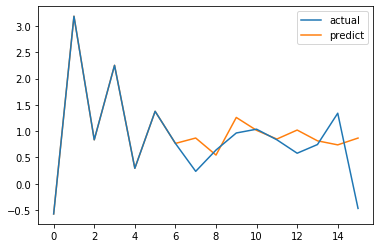

In [187]:
i = 32
plt.plot(np.concatenate((X_train[i, :, -2], y_train[i].reshape(-1)), axis=None), label='actual', zorder=1)
plt.plot(np.concatenate((X_train[i, :, -2], train_pred[i].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.show()

In [135]:
np.concatenate((X_train[i, :, -2], y_train[i]), axis=None)

array([-0.57595346, -0.26224327, -0.57595346,  0.36517711, -0.57595346,
        0.36517711,  0.54278903, -0.26224327, -0.57595346, -0.57595346,
        3.1885688 , -0.57595346, -0.57595346, -0.57595346, -0.57595346,
       -0.57595346])

In [132]:
X_train[i, :, -2]

array([-0.57595346, -0.26224327, -0.57595346,  0.36517711, -0.57595346])

In [133]:
y_train[i]

array([ 0.36517711,  0.54278903, -0.26224327, -0.57595346, -0.57595346,
        3.1885688 , -0.57595346, -0.57595346, -0.57595346, -0.57595346,
       -0.57595346])

In [206]:
X = np.array([
    [1,2,3,4],
    [11,12,13,14],
    [21,22,23,24],
    [33,32,33,34]
])

y = np.array([
    [5,6,7],
    [15,16,17],
    [25,26,27],
    [35,36,37]
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [207]:
X_train

array([[ 1,  2,  3,  4],
       [33, 32, 33, 34],
       [11, 12, 13, 14]])

In [208]:
y_train

array([[ 5,  6,  7],
       [35, 36, 37],
       [15, 16, 17]])

In [198]:
y_test

array([[5, 6, 7]])

In [200]:
X_test

array([[15, 16, 17],
       [35, 36, 37],
       [25, 26, 27]])